## Neural Machine Translation

## Introduction
In this notebook, we will build a deep neural network that functions as part of an end-to-end machine translation pipeline. The completed pipeline will accept french text as input and return the english translation.

__Proposed Approach__

- Preprocessing: Load and examine data, cleaning, tokenization, padding
- Modeling: Build an encoder-decoder model with Attention
- Prediction: Generate specific translations of French to English, and compare the output translations to the ground truth translations

In [1]:
from __future__ import print_function, division
from builtins import range, input

import os, sys
import string
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, \
  Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import adam
from keras import optimizers
from sklearn.model_selection import train_test_split

% matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.
UsageError: Line magic function `%` not found.


### Model Configurations

In [2]:
# config
BATCH_SIZE = 1024
EPOCHS = 30
LATENT_DIM = 256
LATENT_DIM_DECODER = 256 
EMBEDDING_DIM = 300


## Dataset
We begin by investigating the dataset that will be used to train and evaluate your pipeline.  

### Load Data
The `data_en` file contains English sentences with their French translations in the `data_fr` file. Load the English and French data from these files from running the cell below.

In [4]:
french_sentences = []
english_sentences = []

test_source_sent = []
test_target_sent = []

#Read files from folder
with open('data_fr', encoding='utf-8') as f:
    for l_i, line in enumerate(f):
        french_sentences.append(line)
        
        
            
with open('data_en', encoding='utf-8') as f:
    for l_i, line in enumerate(f):
        english_sentences.append(line)      
        
#Calculate the dataset size            
assert len(french_sentences)==len(english_sentences),'Source: %d, Target: %d'%(len(french_sentences),len(english_sentences))

df=pd.DataFrame(french_sentences,columns=['fra'])
df['eng']=english_sentences
df=df[0:50000]
print('Sample translations (%d)'%len(french_sentences))
for i in range(0,2):
    print('(',i,') FR: ', df.iloc[i,0])
    print('(',i,') EN: ', df.iloc[i,1])
    

Sample translations (137860)
( 0 ) FR:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .

( 0 ) EN:  new jersey is sometimes quiet during autumn , and it is snowy in april .

( 1 ) FR:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .

( 1 ) EN:  the united states is usually chilly during july , and it is usually freezing in november .



### Train Test Split

In [5]:
fr_train, fr_test, en_train, en_test = train_test_split(df["fra"],df["eng"], test_size=0.2, random_state = 12)

In [6]:
input_texts = [] # French sentences
target_texts = [] # English sentences
target_texts_inputs = []# english sentences offset by 1 for teacher forcing

#Converting to lowercase
fr_train=[line.lower() for line in fr_train]
en_train=[line.lower() for line in en_train]
NUM_SAMPLES=len(fr_train)
print("Sample train size:",NUM_SAMPLES)

Sample train size: 40000


From looking at the sentences, you can see that they have been preprocessed already.  The puncuations have been delimited using spaces. All the text have been converted to lowercase.  This should save you some time, but the text requires more preprocessing.

## Preprocess
For this project, you won't use text data as input to your model. Instead, you'll convert the text into sequences of integers using the following preprocess methods:
1. Add start and end tokens to the sentences
2. Tokenize the words of the sentences
3. Add padding to make all the sequences of same length.

Time to start preprocessing the data...
### Tokenize 
For a neural network to predict on text data, it first has to be turned into data it can understand. Text data like "dog" is a sequence of ASCII character encodings.  Since a neural network is a series of multiplication and addition operations, the input data needs to be number(s).

We can turn each character into a number or each word into a number.  These are called character and word ids, respectively.  Character ids are used for character level models that generate text predictions for each character.  A word level model uses word ids that generate text predictions for each word.  Word level models tend to learn better, since they are lower in complexity, so we'll use those.

Turn each sentence into a sequence of words ids using Keras's [`Tokenizer`](https://keras.io/preprocessing/text/#tokenizer) function. Use this function to tokenize `english_sentences` and `french_sentences` in the cell below.


### Padding
When batching the sequence of word ids together, each sequence needs to be the same length. Since sentences are dynamic in length, we can add padding to the end of the sequences to make them the same length.

Make sure all the English sequences have the same length and all the French sequences have the same length by adding padding to the end of each sequence using Keras's [`pad_sequences`](https://keras.io/preprocessing/sequence/#pad_sequences) function.

__Preprocess Train Data__

In [7]:
#Adding <sos> and <eos> tokens

for lines in en_train:
    target_texts_inputs.append('<sos>'+" "+ lines)
    
for lines in en_train:
    target_texts.append(lines+ " " +'<eos>')
    
for lines in fr_train:
    input_texts.append(lines)

In [8]:
# tokenize French sentences
tokenizer_inputs = Tokenizer()
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

# word to index mapping for French
word2idx_inputs = tokenizer_inputs.word_index

# Max length of French sentence
max_len_input = max(len(s) for s in input_sequences)

#tokenize English sentences
tokenizer_outputs = Tokenizer(filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) 
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

# Word to index mapping for English
word2idx_outputs = tokenizer_outputs.word_index

# store number of output words for later
num_words_output = len(word2idx_outputs) + 1

# Max length of English sentence
max_len_target = max(len(s) for s in target_sequences)

# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

print('Data Preprocessed')
print("Max train English sentence length:", max_len_target)
print("Max train French sentence length:", max_len_input)


Data Preprocessed
Max train English sentence length: 18
Max train French sentence length: 20


__Preprocess Test Data__

In [9]:
##Test Preparation
input_texts_test = [] # French sentences
target_texts_test = [] # English sentences
target_texts_inputs_test = []# english sentences offset by 1 for teacher forcing

#Converting to lowercase
fr_test=[line.lower() for line in fr_test]
en_test=[line.lower() for line in en_test]

In [10]:
#Adding <sos> and <eos> tokens

for lines in en_test:
    target_texts_inputs_test.append('<sos>'+" "+ lines)
    
for lines in en_test:
    target_texts_test.append(lines+ " " +'<eos>')
    
for lines in fr_test:
    input_texts_test.append(lines)

In [11]:
# tokenize French sentences

input_sequences_test = tokenizer_inputs.texts_to_sequences(input_texts_test)


target_sequences_test = tokenizer_outputs.texts_to_sequences(target_texts_test)
target_sequences_inputs_test = tokenizer_outputs.texts_to_sequences(target_texts_inputs_test)

# pad the sequences
encoder_inputs_test = pad_sequences(input_sequences_test, maxlen=max_len_input)
decoder_inputs_test = pad_sequences(target_sequences_inputs_test, maxlen=max_len_target, padding='post')
decoder_targets_test = pad_sequences(target_sequences_test, maxlen=max_len_target, padding='post')

print("Max test English sentence length:", decoder_inputs_test.shape[1])
print("Max test French sentence length:", encoder_inputs_test.shape[1])

Max test English sentence length: 18
Max test French sentence length: 20


### Embedding

In word embeddings, every word is represented as an n-dimensional dense vector. The words that are similar will have similar vector. The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used.

For French sentences, i.e. the inputs, we will use the [`GloVe`](https://nlp.stanford.edu/projects/glove/) word embeddings. For the translated English sentences in the output, we will use custom word embeddings.

Let's create word embeddings for the inputs first. To do so, we need to load the GloVe word vectors into memory. We will then create a dictionary where words are the keys and the corresponding vectors are values, as shown below:

In [31]:
#Load pretrained word vectors from Glove
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('glove.6B.%sd.txt' % EMBEDDING_DIM), encoding="utf8") as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))


Loading word vectors...
Found 400000 word vectors.


In [14]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words=len(word2idx_inputs) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < num_words:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


### Creating the Model
The idea is to have two recurrent neural networks (RNNs) with an encoder-decoder architecture: read the input words one by one to obtain a vector representation of a fixed dimensionality (encoder), and, conditioned on these inputs, extract the output words one by one using another RNN (decoder).


### Define Softmax Activation Function

In [15]:
def softmax_over_time(x):
  assert(K.ndim(x) > 2)
  e = K.exp(x - K.max(x, axis=1, keepdims=True))
  s = K.sum(e, axis=1, keepdims=True)
  return e / s

### Define Embedding Layer

In [16]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)


### One-hot Encoding

To make predictions, the final layer of the model will be a dense layer, therefore we need the outputs in the form of one-hot encoded vectors, since we will be using softmax activation function at the dense layer. To create such one-hot encoded output, the next step is to assign 1 to the column number that corresponds to the integer representation of the word. 

In [17]:

decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    decoder_targets_one_hot[i, t, word] = 1

### Define Encoding Layer
The input to the encoder will be the sentence in French and the output will be the hidden state and cell state of the LSTM.

In [18]:
#encoder
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = Bidirectional(LSTM(
  LATENT_DIM,
  return_sequences=True,
))
encoder_outputs = encoder(x)


### Define Decoder Layer

The next step is to define the decoder. The decoder will have two inputs: the hidden state and cell state from the encoder and the input sentence, which actually will be the output sentence with an "</sos/>" token appended at the beginning.

In [19]:
#Decoder
decoder_inputs_placeholder = Input(shape=(max_len_target,))
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)



### Define Attention Layers

To improve the performance of the Neural Machine Translator, Attention mechanism (Dot attention) is implemented. The attention model develops a context vector that is filtered specifically for each output time step.

Attention places different focus on different words by assigning each word with a score. Then, using the softmaxed scores, we aggregate the encoder hidden states using a weighted sum of the encoder hidden states, to get the context vector. 

Rather than re-iterating through the equations for calculating attention, a function `one_step_attention` is defined. 

In [20]:
#Attention
attn_repeat_layer = RepeatVector(max_len_input)
attn_concat_layer = Concatenate(axis=-1)
attn_dense1 = Dense(10, activation='tanh')
attn_dense2 = Dense(1, activation=softmax_over_time)

attn_dot = Dot(axes=1) # to perform the weighted sum of alpha[t] * h[t]


In [21]:
def one_step_attention(h, st_1):
  # h = h(1), ..., h(Tx), shape = (Tx, LATENT_DIM * 2)
  # st_1 = s(t-1), shape = (LATENT_DIM_DECODER,)
 
  # copy s(t-1) Tx times
  # now shape = (Tx, LATENT_DIM_DECODER)
  st_1 = attn_repeat_layer(st_1)

  # Concatenate all h(t)'s with s(t-1)
  # Now of shape (Tx, LATENT_DIM_DECODER + LATENT_DIM * 2)
  x = attn_concat_layer([h, st_1])

  # Neural net first layer
  x = attn_dense1(x)

  # Neural net second layer with special softmax over time
  alphas = attn_dense2(x)

  # "Dot" the alphas and the h's
  # Remember a.dot(b) = sum over a[t] * b[t]
  context = attn_dot([alphas, h])

  return context


In [22]:
# define the rest of the decoder (after attention)
decoder_lstm = LSTM(LATENT_DIM_DECODER, return_state=True)
decoder_dense = Dense(num_words_output, activation='softmax')

initial_s = Input(shape=(LATENT_DIM_DECODER,), name='s0')
initial_c = Input(shape=(LATENT_DIM_DECODER,), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)

In [23]:
# s, c will be re-assigned in each iteration of the loop
s = initial_s
c = initial_c

# collect outputs in a list at first
outputs = []
for t in range(max_len_target): # Ty times
  # get the context using attention
  context = one_step_attention(encoder_outputs, s)

  # we need a different layer for each time step
  selector = Lambda(lambda x: x[:, t:t+1])
  xt = selector(decoder_inputs_x)
  
  # combine 
  decoder_lstm_input = context_last_word_concat_layer([context, xt])

  # pass the combined [context, last word] into the LSTM
  # along with [s, c]
  # get the new [s, c] and output
  o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])

  # final dense layer to get next word prediction
  decoder_outputs = decoder_dense(o)
  outputs.append(decoder_outputs)

In [24]:
def stack_and_transpose(x):
  # x is a list of length T, each element is a batch_size x output_vocab_size tensor
  x = K.stack(x) # is now T x batch_size x output_vocab_size tensor
  x = K.permute_dimensions(x, pattern=(1, 0, 2)) # is now batch_size x T x output_vocab_size
  return x

# make it a layerx``
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)


In [25]:
# create the model
model = Model(
  inputs=[
    encoder_inputs_placeholder,
    decoder_inputs_placeholder,
    initial_s, 
    initial_c,
  ],
  outputs=outputs
)

### Model Training

In [26]:
learning_rate=0.001
# checkpoint
filepath="french_eng_finalmodel"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# compile the model

model.compile(optimizer=optimizers.Adam(learning_rate) ,loss='categorical_crossentropy', metrics=['accuracy'])


In [27]:
# train the model
z = np.zeros((encoder_inputs.shape[0], LATENT_DIM_DECODER)) # initial [s, c]
r = model.fit(
  [encoder_inputs, decoder_inputs, z, z], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
    callbacks=callbacks_list
)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 166s 5ms/step - loss: 3.5001 - accuracy: 0.2610 - val_loss: 2.7392 - val_accuracy: 0.3689

Epoch 00001: val_accuracy improved from -inf to 0.36892, saving model to french_eng_finalmodel
Epoch 2/30
32000/32000 [==============================] - 160s 5ms/step - loss: 2.3606 - accuracy: 0.4976 - val_loss: 2.0123 - val_accuracy: 0.5802

Epoch 00002: val_accuracy improved from 0.36892 to 0.58021, saving model to french_eng_finalmodel
Epoch 3/30
32000/32000 [==============================] - 160s 5ms/step - loss: 1.7014 - accuracy: 0.6247 - val_loss: 1.4083 - val_accuracy: 0.6718

Epoch 00003: val_accuracy improved from 0.58021 to 0.67181, saving model to french_eng_finalmodel
Epoch 4/30
32000/32000 [==============================] - 160s 5ms/step - loss: 1.2054 - accuracy: 0.7013 - val_loss: 

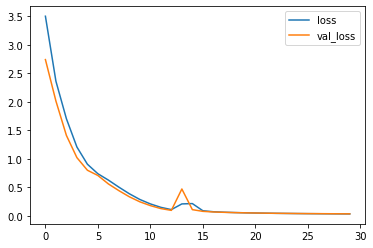

In [28]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()



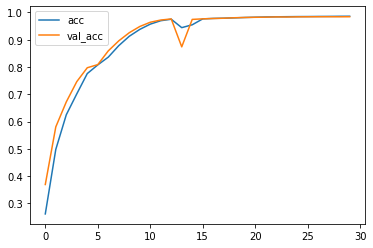

In [29]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()


### Modifying the model for Predictions
While training, we know the actual inputs to the decoder for all the output words in the sequence. However, during predictions the next word will be predicted on the basis of the previous word, which in turn is also predicted in the previous time-step. 

While making actual predictions, the full output sequence is not available, in fact that is what we have to predict. During prediction the only start and end token is avaialbale to us. We will use this to predict the output sentences. 

In [30]:
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

# next we define a T=1 decoder model
encoder_outputs_as_input = Input(shape=(max_len_input, LATENT_DIM * 2,))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# no need to loop over attention steps this time because there is only one step
context = one_step_attention(encoder_outputs_as_input, initial_s)

# combine context with last word
decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])

# lstm and final dense
o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(o)

In [31]:
# create the model object
decoder_model = Model(
  inputs=[
    decoder_inputs_single,
    encoder_outputs_as_input,
    initial_s, 
    initial_c
  ],
  outputs=[decoder_outputs, s, c]
)


### Making Predictions

In the tokenization steps, we converted words to integers. The outputs from the decoder will also be integers. However, we want our output to be a sequence of words in the French language. To do so, we need to convert the integers back to words. We will create new dictionaries for both inputs and outputs where the keys will be the integers and the corresponding values will be the words.

In [32]:
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

The decode_sequence() method will accept an input-padded sequence french sentence (in the integer form) and will return the translated english sentence. 

In [33]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  enc_out = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))
  
  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']


  # [s, c] will be updated in each loop iteration
  s = np.zeros((1, LATENT_DIM_DECODER))
  c = np.zeros((1, LATENT_DIM_DECODER))


  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    o, s, c = decoder_model.predict([target_seq, enc_out, s, c])
        

    # Get next word
    idx = np.argmax(o.flatten())

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

  return ' '.join(output_sentence)

### Testing the model
To test the model, we use the french sentences from the test set, retrieve the corresponding padded sequence for the sentence, and will pass it to the decode_sequence() method. The method will return the translated sentence as shown below.

In [34]:
test_actual_sentence=[]
test_predicted_sentence=[]
for i in range(len(fr_test)):
    # Do some test translations
  
  input_seq = encoder_inputs_test[i:i+1]
  translation = decode_sequence(input_seq)

  test_actual_sentence.append(target_texts_test[i])
  test_predicted_sentence.append(translation)

In [37]:
for i in np.random.randint(0,10000,5):
    print('-')
    print('Input sentence:', input_texts_test[i])
    print('Predicted translation:', test_predicted_sentence[i])
    print('Actual translation:', target_texts_test[i])

-
Input sentence: france est calme en novembre , mais il est généralement agréable en juillet .

Predicted translation: france is quiet during november , but it is usually nice in july .

Actual translation: france is quiet during november , but it is usually nice in july .
 <eos>
-
Input sentence: ils pourraient se rendre à paris au printemps prochain .

Predicted translation: they might go to paris next spring .

Actual translation: they might go to paris next spring .
 <eos>
-
Input sentence: new jersey est jamais pluvieux au cours de l' automne , et il est parfois doux en juillet .

Predicted translation: new jersey is never rainy during autumn , and it is sometimes mild in july .

Actual translation: new jersey is never rainy during fall , and it is sometimes mild in july .
 <eos>
-
Input sentence: la banane est son fruit préféré moins , mais le raisin est son moins préféré .

Predicted translation: the banana is his least favorite fruit , but the grape is her least favorite .

Ac

### Evaluation metric: BLEU Score

BLEU, or the Bilingual Evaluation Understudy, is a score for comparing a candidate translation of text to one or more reference translations. NLTK also provides a function called corpus_bleu() for calculating the BLEU score for multiple sentences such as a paragraph or a document.

The references must be specified as a list of sentences where each sentence is a list of references and each alternative reference is a list of tokens, e.g. a list of lists of lists of tokens. The candidate sentences must be specified as a list where each sentence is a list of tokens

Here we will be passing predicted translations as list of candidate sentences and actual sentences as list of reference sentences.


In [39]:
import nltk
pred=[]
for words in test_predicted_sentence:
    pred.append(words.split())

In [40]:
actual=[]
for words in test_actual_sentence:
    actual.append(words.split())

In [45]:
from nltk.translate.bleu_score import SmoothingFunction
chencherry = SmoothingFunction()
BLEUscore = nltk.translate.bleu_score.corpus_bleu(actual,pred,smoothing_function=chencherry.method4)
print(BLEUscore)

0.3300595072757995
